In [31]:
%reset -f 

In [32]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve
)


In [33]:
import numpy as np

# Define data files by system type
data_files = {
    "apo": "apo_inter_protein_distance.npy",
    "ort": "ort_inter_protein_distance.npy",
    "alo": "alo_inter_protein_distance.npy",
    "duo": "duo_inter_protein_distance.npy"
}

# Pair file: maps column indices to residue pairs (14-3-3, alpha-synuclein)
pair_map_file = "apo_residue_pairs.npy"   # Or update as appropriate

X_list = []
y_list = []
label_map = {"apo": 0, "ort": 1, "alo": 2, "duo": 3}
class_names = ["APO", "ORT", "ALO", "DUO"]

for key, path in data_files.items():
    X = np.load(path)
    y = np.full(X.shape[0], label_map[key])
    X_list.append(X)
    y_list.append(y)

# Concatenate all system data
X_all = np.vstack(X_list)
y_all = np.concatenate(y_list)
print(f"Final dataset shape: {X_all.shape}, Labels shape: {y_all.shape}")

# Print the number of labels in each category
for idx, class_name in enumerate(class_names):
    count = np.sum(y_all == idx)
    print(f"{class_name}: {count} samples")

Final dataset shape: (8000, 22213), Labels shape: (8000,)
APO: 2000 samples
ORT: 2000 samples
ALO: 2000 samples
DUO: 2000 samples


In [34]:
# Each row: [14-3-3 residue, alpha-synuclein residue]
pair_map = np.load(pair_map_file)
print(f"Residue pair map shape: {pair_map.shape}")

Residue pair map shape: (22213, 2)


In [35]:
df = pd.DataFrame(X_all)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

In [36]:
print(y_all.shape)
print(X_all.shape)

(8000,)
(8000, 22213)


In [37]:
df_scaled = pd.DataFrame(X_scaled)
df_scaled['label'] = y_all

In [38]:
print(df_scaled.head())

          0         1         2         3         4         5         6  \
0  0.672580  0.749396  1.109189  1.175978  0.852067  0.633713  0.917300   
1  0.805672  0.876978  1.221347  1.116227  0.787383  0.806581  1.197876   
2  0.665090  0.714883  1.057209  0.997399  0.755274  0.696609  1.070321   
3  0.942394  0.959686  1.311234  1.187399  0.892557  0.920847  1.328180   
4  0.760080  0.784241  1.121988  1.047644  0.745139  0.677686  1.053075   

          7         8         9  ...     22204     22205     22206     22207  \
0  0.939351  0.931833  1.158655  ... -0.709020 -0.527512 -0.504388 -0.326492   
1  1.215967  1.305934  1.436196  ... -0.712310 -0.551948 -0.553166 -0.391544   
2  1.025481  1.000309  1.146764  ... -0.715986 -0.545822 -0.530340 -0.353683   
3  1.246946  1.308872  1.458099  ... -0.604948 -0.427079 -0.422086 -0.305720   
4  1.020507  1.058928  1.247019  ... -0.645075 -0.442634 -0.420427 -0.270124   

      22208     22209     22210     22211     22212  label  
0 -0.12

In [39]:
print(df_scaled.shape)

(8000, 22214)


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume df_scaled is your feature matrix with the label column at the end

# 1. Extract features only (exclude label column)
features_pre = df_scaled.iloc[:, :-1]
print('# of features before drop:', features_pre.shape[1])

# of features before drop: 22213


In [42]:
# 2. Compute correlation matrix
# Increasing min_periods will speed up computation, but accuracy drops with higher values
corr_matrix_before = features_pre.corr(min_periods=1).abs()

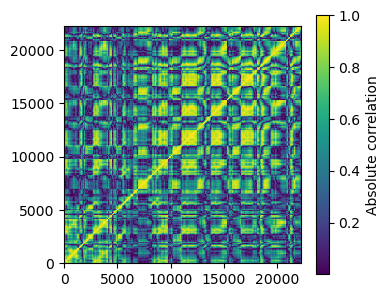

In [44]:
# 3. (Optional) visual check - could be skipped if running headless
plt.figure(figsize=(4,4), tight_layout=True)
plt.imshow(corr_matrix_before, interpolation='nearest', origin='lower')
plt.colorbar(shrink=0.7, label='Absolute correlation')
plt.savefig("correlation_before_filtering.png", dpi=100)

In [46]:
# 4. Shuffle features if desired
arr = np.arange(features_pre.shape[1])
np.random.shuffle(arr)
corr_matrix = corr_matrix_before.iloc[arr, arr]

# 5. Drop features above desired cutoff threshold
cutoff = 0.90
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > cutoff)]

df_dropped = df_scaled.drop(df_scaled.columns[to_drop], axis=1)
print('Number of features after drop is:', df_dropped.shape[1]-1)  # -1 for label column


Number of features after drop is: 321


In [47]:
# 6. (Optional) Visualize the new correlation matrix
features_postcorr = df_dropped.iloc[:, :-1]
corr_matrix_after = features_postcorr.corr(min_periods=1).abs()

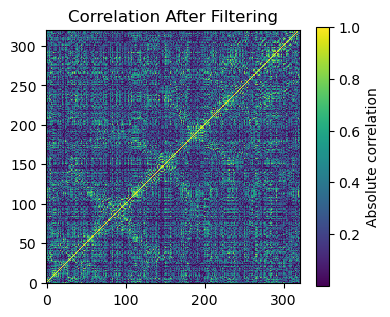

In [48]:
plt.figure(figsize=(4,4), tight_layout=True)
plt.imshow(corr_matrix_after, interpolation='nearest', origin='lower')
plt.colorbar(shrink=0.7, label='Absolute correlation')
plt.title("Correlation After Filtering")
plt.savefig("correlation_after_drop.png", dpi = 100)

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, roc_auc_score, classification_report
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Split data for training/testing
X_train, X_test, y_train, y_test = train_test_split(
    features_final, labels_final, test_size=0.2, random_state=42, stratify=labels_final
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# 2. Extract kept feature indices after feature filtering
kept_feature_indices = features_postcorr.columns.values.astype(int)

# 3. Load residue pair map (make sure to load it outside the train/test split too)
pair_map = np.load(pair_map_file)

# ------- Logistic Regression -------
logreg = LogisticRegression(
    penalty='l1',
    solver='saga',
    multi_class='multinomial',
    max_iter=3000,
    n_jobs=-1,
    random_state=42
)
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
logreg_pred_prob = logreg.predict_proba(X_test)

logreg_acc = accuracy_score(y_test, logreg_pred)
logreg_f1 = f1_score(y_test, logreg_pred, average='weighted')
logreg_prec = precision_score(y_test, logreg_pred, average='weighted')
logreg_auc = roc_auc_score(y_test, logreg_pred_prob, multi_class='ovr')

print("Logistic Regression metrics:")
print(f"  Accuracy:  {logreg_acc:.4f}")
print(f"  F1 Score:  {logreg_f1:.4f}")
print(f"  Precision: {logreg_prec:.4f}")
print(f"  AUC:       {logreg_auc:.4f}\n")
print(classification_report(y_test, logreg_pred))

# Feature importance and top pairs
coef_avg = np.abs(logreg.coef_).mean(axis=0)
top20_logreg_idx = np.argsort(coef_avg)[::-1][:20]
logreg_pairs = pair_map[kept_feature_indices[top20_logreg_idx]]
logreg_csv = pd.DataFrame({
    "Protein1_Residue": logreg_pairs[:, 0],
    "Protein2_Residue": logreg_pairs[:, 1],
    "AvgImportance": coef_avg[top20_logreg_idx]
})
logreg_csv.to_csv("top20_logreg_pairs.csv", index=False)

# ------- Random Forest -------
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_pred_prob = rf.predict_proba(X_test)

rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')
rf_prec = precision_score(y_test, rf_pred, average='weighted')
rf_auc = roc_auc_score(y_test, rf_pred_prob, multi_class='ovr')

print("Random Forest metrics:")
print(f"  Accuracy:  {rf_acc:.4f}")
print(f"  F1 Score:  {rf_f1:.4f}")
print(f"  Precision: {rf_prec:.4f}")
print(f"  AUC:       {rf_auc:.4f}\n")
print(classification_report(y_test, rf_pred))

rf_importance = rf.feature_importances_
top20_rf_idx = np.argsort(rf_importance)[::-1][:20]
rf_pairs = pair_map[kept_feature_indices[top20_rf_idx]]
rf_csv = pd.DataFrame({
    "Protein1_Residue": rf_pairs[:, 0],
    "Protein2_Residue": rf_pairs[:, 1],
    "AvgImportance": rf_importance[top20_rf_idx]
})
rf_csv.to_csv("top20_rf_pairs.csv", index=False)

# ------- MLP Classifier -------
mlp = MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=500, random_state=42, early_stopping=True)
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)
mlp_pred_prob = mlp.predict_proba(X_test)

mlp_acc = accuracy_score(y_test, mlp_pred)
mlp_f1 = f1_score(y_test, mlp_pred, average='weighted')
mlp_prec = precision_score(y_test, mlp_pred, average='weighted')
mlp_auc = roc_auc_score(y_test, mlp_pred_prob, multi_class='ovr')

print("MLP Classifier metrics:")
print(f"  Accuracy:  {mlp_acc:.4f}")
print(f"  F1 Score:  {mlp_f1:.4f}")
print(f"  Precision: {mlp_prec:.4f}")
print(f"  AUC:       {mlp_auc:.4f}\n")
print(classification_report(y_test, mlp_pred))

mlp_weights = np.abs(mlp.coefs_[0]).mean(axis=1)
top20_mlp_idx = np.argsort(mlp_weights)[::-1][:20]
mlp_pairs = pair_map[kept_feature_indices[top20_mlp_idx]]
mlp_csv = pd.DataFrame({
    "Protein1_Residue": mlp_pairs[:, 0],
    "Protein2_Residue": mlp_pairs[:, 1],
    "AvgImportance": mlp_weights[top20_mlp_idx]
})
mlp_csv.to_csv("top20_mlp_pairs.csv", index=False)



Train shape: (6400, 321) Test shape: (1600, 321)


/home/niladri/anaconda3/envs/mdanalysis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression metrics:
  Accuracy:  1.0000
  F1 Score:  1.0000
  Precision: 1.0000
  AUC:       1.0000

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       400
           2       1.00      1.00      1.00       400
           3       1.00      1.00      1.00       400

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

Random Forest metrics:
  Accuracy:  1.0000
  F1 Score:  1.0000
  Precision: 1.0000
  AUC:       1.0000

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       400
           2       1.00      1.00      1.00       400
           3       1.00      1.00      1.00       400

    accuracy                           1.00      1600
   macro avg       1.00  

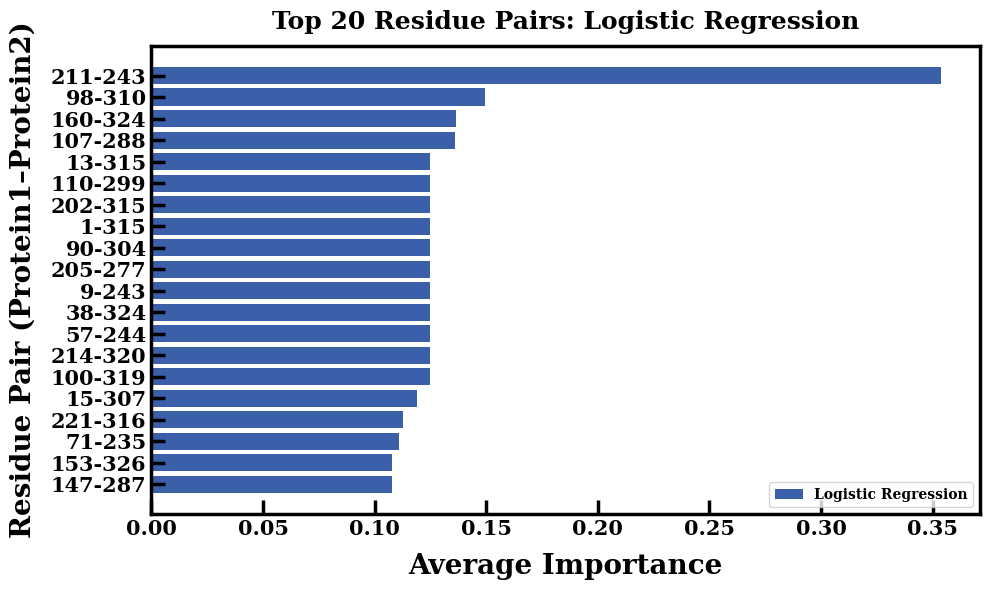

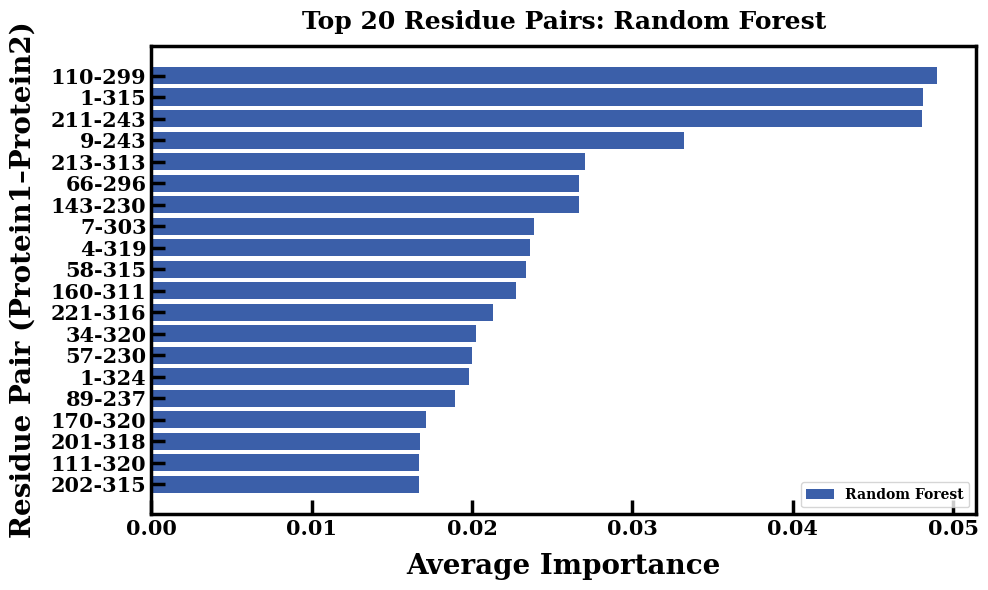

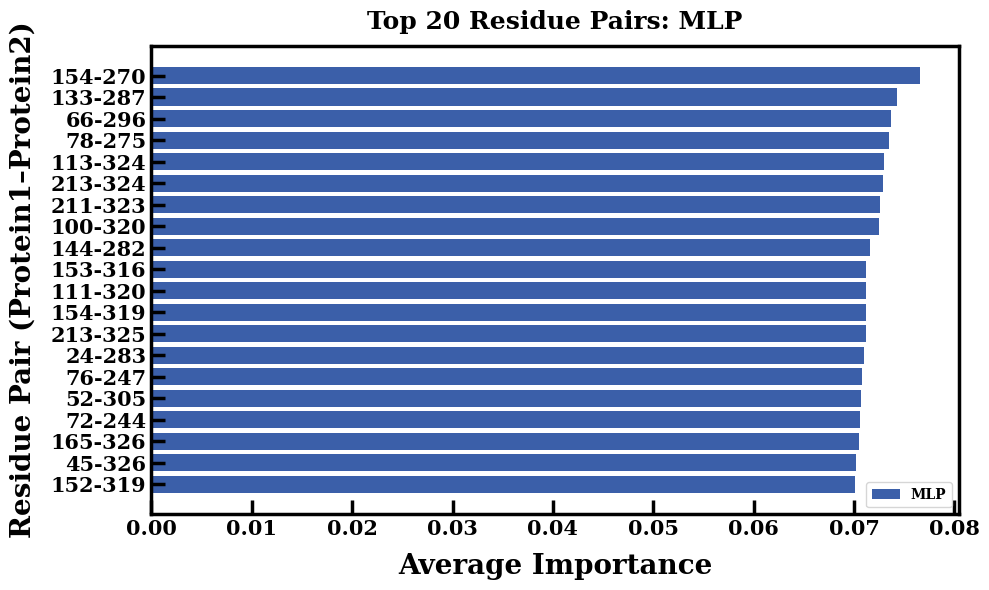

In [54]:
# ------- Bar Plots for Each Model -------
def plot_top_pairs(df, model_name):
    plt.figure(figsize=(10, 6))
    labels = [f"{int(p1)}-{int(p2)}" for p1, p2 in zip(df["Protein1_Residue"], df["Protein2_Residue"])]
    plt.barh(labels, df["AvgImportance"], color="#3b5fa9")
    plt.gca().invert_yaxis()
    plt.xlabel("Average Importance", fontname='serif', fontweight='bold', fontsize=20, labelpad=10)
    plt.ylabel("Residue Pair (Protein1–Protein2)", fontname='serif', fontweight='bold', fontsize=20, labelpad=10)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(2.5)
    plt.tick_params(axis='both', which='major', length=10, width=2.5, direction='in', labelsize=15)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('serif')
        label.set_fontweight('bold')
    plt.title(f"Top 20 Residue Pairs: {model_name}", fontname='serif', fontweight='bold', fontsize=18, pad=12)
    plt.legend([model_name], fontsize=15, fancybox=True, frameon=True, prop={'family': 'serif', 'weight': 'bold'})
    plt.tight_layout()
    plt.show()

plot_top_pairs(logreg_csv, "Logistic Regression")
plot_top_pairs(rf_csv, "Random Forest")
plot_top_pairs(mlp_csv, "MLP")